In [1]:
import pandas as pd, numpy as np, os
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import cross_val_score, validation_curve, train_test_split, GridSearchCV 
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.experimental importt enable_hist_gradient_boosting
import matplotlib.pyplot as plt
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier,HistGradientBoostingClassifier
import xgboost as xgb
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from rgf.sklearn import RGFClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt

In [2]:
#import wildfire data set 
df = pd.read_csv("WildFires_DataSet.csv")

A description of the above dataset can be found here: 
https://github.com/ouladsayadyounes/Wildfires

In [3]:
#snapshot of the data
df.head()

,NDVI,LST,BURNED_AREA,CLASS
0,0.506782,14584.272727,4.692308,no_fire
1,0.522150,14655.833333,5.000000,no_fire
2,0.682284,14780.000000,5.000000,fire
3,0.120046,13298.500000,3.500000,no_fire
4,0.568734,14743.000000,5.000000,no_fire


In [4]:
df.describe()

,NDVI,LST,BURNED_AREA
count,1713.000000,1713.000000,1713.000000
mean,0.555665,14622.802073,4.674973
std,0.092847,366.927861,0.583791
min,0.030735,13137.000000,3.000000
25%,0.501276,14406.000000,4.521951
50%,0.565181,14645.750000,4.920635
75%,0.620987,14881.300000,5.000000
max,0.781723,15611.570513,9.000000


In [5]:
#input/features
X = df[["NDVI", "LST", "BURNED_AREA"]]

#output
y = df["CLASS"]

#replace the categories with numerical values
y.replace({"no_fire":0, "fire":1}, inplace=True)

In [6]:
# Train Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 5)

In [7]:
#Scaler
scaler = StandardScaler()

#### SVM

In [8]:
#### GRID SEARCH ON SVM 
clf = SVC(random_state=5)
# defining parameter range 
param_grid = {'C': np.logspace(1, 2.3, 10),  
              'gamma': np.linspace(0,2, 5), 
              'kernel': ['rbf']}  
  
grid = GridSearchCV(clf, param_grid, refit = True, cv = 5, verbose = 3,
                    error_score=0,
                    n_jobs=-1) 
  
# fitting the model for grid search 
grid.fit(scaler.fit_transform(X_train), y_train) 

#### Best Grid search parameter fitting

# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

grid_predictions = grid.predict(scaler.transform(X_test)) 
  
# print classification report 
print(classification_report(y_test, grid_predictions)) 
print(confusion_matrix(y_test, grid_predictions)) 

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    4.2s finished


{'C': 199.52623149688787, 'gamma': 0.5, 'kernel': 'rbf'}
SVC(C=199.52623149688787, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.5, kernel='rbf',
    max_iter=-1, probability=False, random_state=5, shrinking=True, tol=0.001,
    verbose=False)
              precision    recall  f1-score   support

           0       0.80      0.96      0.87       391
           1       0.64      0.23      0.34       123

    accuracy                           0.78       514
   macro avg       0.72      0.59      0.60       514
weighted avg       0.76      0.78      0.74       514

[[375  16]
 [ 95  28]]


In [9]:
#### Cross val score
scores_SVM = cross_val_score(grid.best_estimator_, scaler.fit_transform(X), y, cv=5)

#print accuracy and standard deviation 
print("Accuracy: %0.3f (+/- %0.2f)" % (scores_SVM.mean(), scores_SVM.std() * 2))

Accuracy: 0.797 (+/- 0.02)


#### BAGGING CLASSIFER

In [11]:
#grid search for bagging classifier using the SVM classifer obtained above 

bag = BaggingClassifier(grid.best_estimator_, n_jobs=-1, n_estimators=5, random_state=5)

param_grid = {'n_estimators': list(range(0, 110, 10))[1:],  'max_features': list (range(1,21, 2))}  

grid = GridSearchCV(bag, param_grid, refit = True, cv = 5, verbose = 3,
                    error_score=0,
                    n_jobs=-1) 
  
# fitting the model for grid search 
grid.fit(scaler.fit_transform(X_train), y_train) 

#### Best Grid search parameter fitting

# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

grid_predictions = grid.predict(scaler.transform(X_test)) 
  
# print classification report 
print(classification_report(y_test, grid_predictions)) 
print(confusion_matrix(y_test, grid_predictions)) 

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


In [12]:
#bagging classifier (SVM)
scores_BAG = cross_val_score(grid.best_estimator_, scaler.fit_transform(X), y, cv=5)

#print accuracy and standard deviation
print("Accuracy: %0.4f (+/- %0.4f)" % (scores_BAG.mean(), scores_BAG.std() * 2))

#### EXTRA TREES CLASSIFIER

In [13]:
#### GRID SEARCH for extra trees classifier 

ext = ExtraTreesClassifier(n_jobs=-1, n_estimators=50, random_state=5)
# defining parameter range 
param_grid = {'n_estimators': list(range(0, 110, 10))[1:],  'max_features': list (range(1,21, 2)), 'max_depth' :list(range(1,21, 2))}  
  

grid = GridSearchCV(ext, param_grid, refit = True, cv = 5, verbose = 3,
                    error_score=0,
                    n_jobs=-1) 
  
# fitting the model for grid search 
grid.fit(scaler.fit_transform(X_train), y_train) 

#### Best Grid search parameter fitting

# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

grid_predictions = grid.predict(scaler.transform(X_test)) 
  
# print classification report 
print(classification_report(y_test, grid_predictions)) 
print(confusion_matrix(y_test, grid_predictions)) 

[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:   52.9s finished


{'max_depth': 13, 'max_features': 3, 'n_estimators': 20}
ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=13, max_features=3,
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
                     oob_score=False, random_state=5, verbose=0,
                     warm_start=False)
              precision    recall  f1-score   support

           0       0.81      0.95      0.88       391
           1       0.67      0.30      0.42       123

    accuracy                           0.80       514
   macro avg       0.74      0.63      0.65       514
weighted avg       0.78      0.80      0.77       514

[[373  18]
 [ 86  37]]


In [14]:
#Accuracy for extra trees classifier 
scores_EXT = cross_val_score(grid.best_estimator_, scaler.fit_transform(X), y, cv=5)

#print accuracy and standard deviation 
print("Accuracy: %0.4f (+/- %0.4f)" % (scores_EXT.mean(), scores_EXT.std() * 2))

Accuracy: 0.8120 (+/- 0.0289)


#### ADABOOST CLASSIFIER

In [15]:
#### GRID SEARCH for Ada bosst classifier 

adb = AdaBoostClassifier(n_estimators=20,learning_rate=0.5, random_state=5)
# defining parameter range 
param_grid = {'n_estimators': list(range(0, 110, 10))[1:],  'learning_rate': [0.2, 0.4, 0.6, 0.8, 1]}  
  

grid = GridSearchCV(adb, param_grid, refit = True, cv = 5, verbose = 3,
                    error_score=0,
                    n_jobs=-1) 
  
# fitting the model for grid search 
grid.fit(scaler.fit_transform(X_train), y_train) 

#### Best Grid search parameter fitting

# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

grid_predictions = grid.predict(scaler.transform(X_test)) 
  
# print classification report 
print(classification_report(y_test, grid_predictions)) 
print(confusion_matrix(y_test, grid_predictions)) 

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    1.6s


{'learning_rate': 0.8, 'n_estimators': 10}
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.8,
                   n_estimators=10, random_state=5)
              precision    recall  f1-score   support

           0       0.77      1.00      0.87       391
           1       1.00      0.06      0.11       123

    accuracy                           0.77       514
   macro avg       0.89      0.53      0.49       514
weighted avg       0.83      0.77      0.69       514

[[391   0]
 [116   7]]


[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    2.4s finished


In [16]:
#Adaboost classifier 
scores_ADB = cross_val_score(grid.best_estimator_, scaler.fit_transform(X), y, cv=5)

#print accuracy and standard deviation
print("Accuracy: %0.4f (+/- %0.4f)" % (scores_ADB.mean(), scores_ADB.std() * 2))

Accuracy: 0.7939 (+/- 0.0190)


#### GRADIENT BOOSTING

In [17]:
#Gradient Boosting 
gb_clf2 = GradientBoostingClassifier(n_estimators=20, learning_rate=0.3, max_features=2, max_depth=2, subsample=0.289, random_state=5)
# defining parameter range 
param_grid = {'n_estimators': list(range(0, 110, 10))[1:],  'max_features': list (range(1,21, 2)), 'max_depth' :list(range(1,21, 2))}  
  

grid = GridSearchCV(gb_clf2, param_grid, refit = True, cv = 5, verbose = 3,
                    error_score=0,
                    n_jobs=-1) 
  
# fitting the model for grid search 
grid.fit(scaler.fit_transform(X_train), y_train) 

#### Best Grid search parameter fitting

# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

grid_predictions = grid.predict(scaler.transform(X_test)) 
  
# print classification report 
print(classification_report(y_test, grid_predictions)) 
print(confusion_matrix(y_test, grid_predictions)) 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 3232 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 4628 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:   24.2s finished


{'max_depth': 17, 'max_features': 1, 'n_estimators': 70}
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.3, loss='deviance', max_depth=17,
                           max_features=1, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=70,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=5, subsample=0.289, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
              precision    recall  f1-score   support

           0       0.83      0.91      0.87       391
           1       0.59      0.42      0.49       123

    accuracy                           0.79       514
   macro avg       0.71      0.6

In [18]:
#Gradient boosting classfier 
scores_GB = cross_val_score(grid.best_estimator_, scaler.fit_transform(X), y, cv=5)

#print accuracy and standard deviation
print("Accuracy: %0.4f (+/- %0.4f)" % (scores_GB.mean(), scores_GB.std() * 2))

Accuracy: 0.8115 (+/- 0.0293)


#### XGBOOST

In [19]:
xg_clf = xgb.XGBClassifier(objective ='multi:softprob', eta = 0.3,   
   
    num_class =2, colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 20, random_state=5)

param_grid = {'n_estimators': list(range(0, 110, 10))[1:] ,  'max_features': list (range(1,21, 2)), 'max_depth':list(range(1,21, 2))}  
  

grid = GridSearchCV(xg_clf , param_grid, refit = True, cv = 5, verbose = 3,
                    error_score=0,
                    n_jobs=-1) 
  
# fitting the model for grid search 
grid.fit(scaler.fit_transform(X_train), y_train) 

#### Best Grid search parameter fitting

# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

grid_predictions = grid.predict(scaler.transform(X_test)) 
  
# print classification report 
print(classification_report(y_test, grid_predictions)) 
print(confusion_matrix(y_test, grid_predictions)) 

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1168 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 2960 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 4914 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:   19.2s finished


{'max_depth': 3, 'max_features': 1, 'n_estimators': 90}
XGBClassifier(alpha=10, base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, eta=0.3, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=3, max_features=1,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=90, n_jobs=0, num_class=2, num_parallel_tree=1,
              objective='multi:softprob', random_state=5, reg_alpha=10,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method=None, validate_parameters=False, ...)
              precision    recall  f1-score   support

           0       0.77      0.99      0.87       391
           1       0.69      0.07      0.13       123

    accuracy                           0.77       514
   macro avg       0.73      0.53      0.50       514
weighted avg   

In [20]:
#Extreme Gradient Boosting classifier 
scores_XGB = cross_val_score(grid.best_estimator_, scaler.fit_transform(X), y, cv=5)

#print accuracy and standard deviation
print("Accuracy: %0.4f (+/- %0.4f)" % (scores_XGB.mean(), scores_XGB.std() * 2))

Accuracy: 0.7887 (+/- 0.0105)


#### RANDOM FOREST

In [21]:
#Random Forest

rf_clf2 = RandomForestClassifier(n_estimators=100, max_depth = 18, 
                                   min_samples_split = 2,  min_samples_leaf = 1,random_state=5, oob_score=True, bootstrap=True)


param_grid = {'n_estimators': list(range(0, 110, 10))[1:], 'max_features': list (range(1,21, 2)), 'max_depth' :list(range(0,21, 2))[1:]}  
  

grid = GridSearchCV(rf_clf2 , param_grid, refit = True, cv = 5, verbose = 3,
                    error_score=0,
                    n_jobs=-1) 
  
# fitting the model for grid search 
grid.fit(scaler.fit_transform(X_train), y_train) 

#### Best Grid search parameter fitting

# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

grid_predictions = grid.predict(scaler.transform(X_test)) 
  
# print classification report 
print(classification_report(y_test, grid_predictions)) 
print(confusion_matrix(y_test, grid_predictions)) 

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 928 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 2720 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 4856 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done 4969 out of 5000 | elapsed:   21.7s remaining:    0.1s


{'max_depth': 16, 'max_features': 1, 'n_estimators': 40}
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=16, max_features=1,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40,
                       n_jobs=None, oob_score=True, random_state=5, verbose=0,
                       warm_start=False)
              precision    recall  f1-score   support

           0       0.83      0.94      0.88       391
           1       0.69      0.40      0.51       123

    accuracy                           0.81       514
   macro avg       0.76      0.67      0.70       514
weighted avg       0.80      0.81      0.79       514

[[369  22]
 [ 74  49]]


[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:   22.2s finished


In [22]:
#Random Forest classfier 
scores_RF = cross_val_score(grid.best_estimator_, scaler.fit_transform(X), y, cv=5)

#print accuracy and standard deviation
print("Accuracy: %0.4f (+/- %0.4f)" % (scores_RF.mean(), scores_RF.std() * 2))

Accuracy: 0.8476 (+/- 0.0244)


#### SKLEARN NEURAL NET

In [23]:
ml_clf2 = MLPClassifier(hidden_layer_sizes=30
                        , activation='relu', solver='adam', alpha=1, random_state=5)
param_grid = {'hidden_layer_sizes': list(range(0, 51, 5))[1:]}  
  

grid = GridSearchCV(ml_clf2 , param_grid, refit = True, cv = 5, verbose = 3,
                    error_score=0,
                    n_jobs=-1) 
  
# fitting the model for grid search 
grid.fit(scaler.fit_transform(X_train), y_train) 

#### Best Grid search parameter fitting

# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

grid_predictions = grid.predict(scaler.transform(X_test)) 
  
# print classification report 
print(classification_report(y_test, grid_predictions)) 
print(confusion_matrix(y_test, grid_predictions)) 

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  50 | elapsed:    1.6s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.0s finished


{'hidden_layer_sizes': 50}
MLPClassifier(activation='relu', alpha=1, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=50, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=5, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
              precision    recall  f1-score   support

           0       0.77      0.98      0.86       391
           1       0.53      0.07      0.13       123

    accuracy                           0.76       514
   macro avg       0.65      0.53      0.50       514
weighted avg       0.71      0.76      0.69       514

[[383   8]
 [114   9]]


In [24]:
#MLP Classifier
scores_NN = cross_val_score(grid.best_estimator_, scaler.fit_transform(X), y, cv=5)

#print accuracy and standard deviation
print("Accuracy: %0.4f (+/- %0.4f)" % (scores_NN.mean(), scores_NN.std() * 2))

Accuracy: 0.7828 (+/- 0.0150)


#### NEAREST NEIGHBOUR

In [25]:
neigh = KNeighborsClassifier(n_neighbors=3, algorithm="brute")
param_grid = {'n_neighbors': list(range(1, 15, 2))}  

grid = GridSearchCV(neigh , param_grid, refit = True, cv = 5, verbose = 3,
                    error_score=0,
                    n_jobs=-1) 
  
# fitting the model for grid search 
grid.fit(scaler.fit_transform(X_train), y_train) 

#### Best Grid search parameter fitting

# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

grid_predictions = grid.predict(scaler.transform(X_test)) 
  
# print classification report 
print(classification_report(y_test, grid_predictions)) 
print(confusion_matrix(y_test, grid_predictions)) 
neigh.fit(scaler.fit_transform(X_train), y_train)
predictions = neigh.predict(scaler.transform(X_test))

print(classification_report(y_test, predictions)) 
print(accuracy_score(y_test, predictions))

Fitting 5 folds for each of 7 candidates, totalling 35 fits
{'n_neighbors': 11}
KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=11, p=2,
                     weights='uniform')
              precision    recall  f1-score   support

           0       0.80      0.94      0.86       391
           1       0.56      0.24      0.33       123

    accuracy                           0.77       514
   macro avg       0.68      0.59      0.60       514
weighted avg       0.74      0.77      0.74       514

[[368  23]
 [ 94  29]]
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       391
           1       0.47      0.38      0.42       123

    accuracy                           0.75       514
   macro avg       0.64      0.62      0.63       514
weighted avg       0.73      0.75      0.74       514

0.7490272373540856


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  35 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  28 out of  35 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.1s finished


In [26]:
#Nearest NEighbour Classifier
scores_NNeigh = cross_val_score(grid.best_estimator_, scaler.fit_transform(X), y, cv=5)

#print accuracy and standard deviation
print("Accuracy: %0.4f (+/- %0.4f)" % (scores_NNeigh.mean(), scores_NNeigh.std() * 2))

Accuracy: 0.7846 (+/- 0.0321)


#### GAUSSIAN NAIVE BAYES

In [27]:
#NAive bayes classfier
gnb = GaussianNB()
scores_NB = cross_val_score(gnb, scaler.fit_transform(X), y, cv=5)

#print accuracy and standard deviation
print("Accuracy: %0.4f (+/- %0.4f)" % (scores_NB.mean(), scores_NB.std() * 2))

Accuracy: 0.7776 (+/- 0.0128)


#### STOCHASTIC GRADIENT

In [28]:
param_grid = {'loss': ['hinge', 'log', 'modified_huber',
    'squared_hinge', 'perceptron', 'squared_loss',
    'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive']}
sgc = SGDClassifier(random_state=5)
grid = GridSearchCV(sgc , param_grid, refit = True, cv = 5, verbose = 3,
                    error_score=0,
                    n_jobs=-1) 
  
# fitting the model for grid search 
grid.fit(scaler.fit_transform(X_train), y_train) 

#### Best Grid search parameter fitting

# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

grid_predictions = grid.predict(scaler.transform(X_test)) 
  
# print classification report 
print(classification_report(y_test, grid_predictions)) 
print(confusion_matrix(y_test, grid_predictions)) 
neigh.fit(scaler.fit_transform(X_train), y_train)
predictions = neigh.predict(scaler.transform(X_test))
print(classification_report(y_test, predictions)) 


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  45 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  30 out of  45 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    0.2s finished


{'loss': 'huber'}
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='huber',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=5, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
              precision    recall  f1-score   support

           0       0.76      0.98      0.86       391
           1       0.00      0.00      0.00       123

    accuracy                           0.75       514
   macro avg       0.38      0.49      0.43       514
weighted avg       0.58      0.75      0.65       514

[[385   6]
 [123   0]]
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       391
           1       0.47      0.38      0.42       123

    accuracy                           0.75    

In [29]:
#Stochastic Gradient boosting classifier 
scores_SGD = cross_val_score(grid.best_estimator_, scaler.fit_transform(X), y, cv=5)

#print accuracy and standard deviation
print("Accuracy: %0.4f (+/- %0.4f)" % (scores_SGD.mean(), scores_SGD.std() * 2))

Accuracy: 0.7735 (+/- 0.0043)


#### PLOT BAR CHART

SVM = Support Vector Machine <br>
BAG_SVM = bagging Classifers (of SVMs)<br>
EXT = Extra Trees Classifer <br>
ADB = Adabost Classifier<br>
GB = Gradient Boosting <br>
XGB = Extreme Gradient Boosting <br>
RF = Random Forest <br>
NN = Neural Network <br>
NNEIGH = Nearest Neighbour <br>
SGD = Stochastic Gradient Descent 

In [32]:
models = ['SVM', 'BAG_SVM', 'EXT', 'ADB', 'GB', 'XGB', 'RF', 'NN', 'NNEIGH', 'NB', 'SGD']
x_pos = np.arange(len(models))
mean = [scores_SVM.mean(), scores_BAG.mean(), scores_EXT.mean(), scores_ADB.mean(), scores_GB.mean(), scores_XGB.mean(), scores_RF.mean(),scores_NN.mean(), scores_NNeigh.mean(), scores_NB.mean(), scores_SGD.mean() ]
std = [scores_SVM.std(), scores_BAG.std(), scores_EXT.std(), scores_ADB.std(), scores_GB.std(), scores_XGB.std(), scores_RF.std(),scores_NN.std(), scores_NNeigh.std(), scores_NB.std(), scores_SGD.std() ]

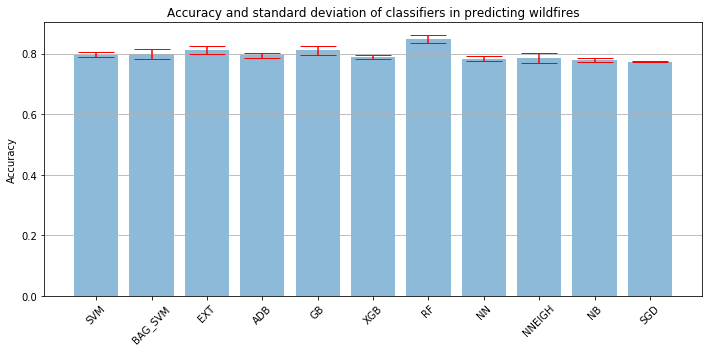

In [33]:
#plot with 
fig, ax = plt.subplots(figsize =(10,5))
ax.bar(x_pos, mean, yerr=std, align='center', alpha=0.5, ecolor='red', capsize=18)
ax.set_ylabel('Accuracy')
ax.set_xticks(x_pos)
ax.set_xticklabels(models, rotation=45)
ax.set_title('Accuracy and standard deviation of classifiers in predicting wildfires')
ax.yaxis.grid(True)
# Save the figure and show
plt.tight_layout()
plt.savefig("accuracy")
plt.show()

More details on the result analysis can be found in my blogpost: https://sites.tufts.edu/olukunleowolabi/2020/03/15/a-comprehensive-classification-model-for-predicting-wildfires-with-uncertainty/